In [1]:
import torch
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import os

In [2]:
TEST_SPLIT = 0.1
VAL_SPLIT = 0.2
BATCH_SIZE = 16

In [3]:
# Mount Google Drive
from google.colab import drive
import os

drive.mount('/content/gdrive')
# Define base folder path
base_path = '/content/gdrive/MyDrive/yoga_proj'
!ls /content/gdrive/MyDrive/yoga_proj
# base_path = '../'

Mounted at /content/gdrive
data  nov16_unknown_attention  official_dataset


In [4]:
import os

# Gets label
csv_path = os.path.join(base_path,'data/3DYoga90_corrected.csv')

SAVE_PATH = os.path.join(base_path, 'nov16_unknown_attention')
os.makedirs(SAVE_PATH, exist_ok=True)

# Classification classes
pose_list = ['mountain', 'half-way-lift', 'standing-forward-bend', 'downward-dog']
# pose_list = ['mountain', 'half-way-lift', 'downward-dog']
# pose_list = ['mountain', 'standing-forward-bend', 'downward-dog']
# pose_list = ['half-way-lift', 'standing-forward-bend', 'downward-dog']
# pose_list = ['mountain', 'half-way-lift', 'standing-forward-bend']
NUM_CLASSES = len(pose_list)

dataset_dir = os.path.join(base_path, 'official_dataset')
assert os.path.isdir(dataset_dir), f"Directory '{dataset_dir}' does not exist."


In [5]:
print(torch.__version__)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

2.5.1+cu121


In [6]:
meta_info_path = os.path.join(base_path, 'data')
pose_index = pd.read_csv(f'{meta_info_path}/pose-index.csv')
sequence_index = pd.read_csv(f'{meta_info_path}/3DYoga90_corrected.csv')

pose_index.head()

,level1_id,level1_pose,level2_id,level2_pose,l3_pose_id,13_pose
0,1,standing,11,standing-straight,101,mountain
1,1,standing,11,standing-straight,102,goddess
2,1,standing,11,standing-straight,103,eagle
3,1,standing,11,standing-straight,104,tree
4,1,standing,11,standing-straight,105,chair


In [7]:
list_poses = [p for p in sequence_index['l3_pose']]
pose_dict = dict()
for poses in list_poses:
    if poses in pose_dict:
        pose_dict[poses] += 1
    else:
        pose_dict[poses] =1
sorted(pose_dict.items(), key= lambda item: item[1])
poses = ['mountain',
'half-way-lift',
'standing-forward-bend',
'downward-dog',
'high-lunge',
'low-lunge',
'warrior-3',
'side-plank',
'balancing-table',
'child',
'tree',
'extended-triangle',
'bridge']
for keys in poses:
    print(keys, pose_dict[keys])

sum(map(lambda k: pose_dict[k], poses))

mountain 164
half-way-lift 210
standing-forward-bend 225
downward-dog 246
high-lunge 42
low-lunge 44
warrior-3 47
side-plank 48
balancing-table 44
child 47
tree 69
extended-triangle 107
bridge 41


1334

What does each file tell?

1.) pose-index.csv -> Shows Heirarchical organization (THEN NOTHING MORE)

2.) 3DYoga90.csv -> Total Main Info(i.e. along with RGB stream){
    SequneceID: Parquet_FILE_NAME,
    URL,
    Frame Start and Frame Stop,
    Pose Name, Training Test Split
} `Difference between train and test? where to get the validation set from? How to do data augmentation?

3.) Parquet Files -> {
    Frame Number {
        33 Landmarks
    },
    row-id: FrameNumber-TYPE-Landmark_index,
    Coordinates: {x, y, z}
}

`PLEASE NOTE: The landmark coordinates are all normalized`

# Getting the data ready

In [8]:
the_desired_poses = [
  'downward-dog',
  'high-lunge',
  'low-lunge',
  'warrior-3',
  'side-plank',
  'balancing-table',
  'child',
  'tree',
  'extended-triangle',
  'bridge']

subset_of_poses = [
  'mountain',
  'downward-dog',
  'standing-foward-bend',
  'half-way-lift'
]

subset_of_poses = pose_list

In [9]:
# Keep only relevant columns
def read_meta_data():
    meta_info_path = os.path.join(base_path, 'data')
    pose_index = pd.read_csv(f'{meta_info_path}/pose-index.csv')
    sequence_index = pd.read_csv(f'{meta_info_path}/3DYoga90_corrected.csv')
    parquet_index = sequence_index[['sequence_id', 'l3_pose', 'split']]
    return parquet_index

In [10]:
import torch
from torch.utils.data import Dataset
import pandas as pd
import numpy as np

class Yoga3DDataset(Dataset):
    def __init__(self, parquet_index, root_dir =  dataset_dir,subset_of_poses= subset_of_poses, sub_sampling_length = 20, transform=None, max_frames=None):
        self.parquet_index = parquet_index
        self.parquet_index = self.parquet_index[self.parquet_index['l3_pose'].isin(subset_of_poses)]
        self.root_dir = root_dir
        self.transform = transform
        self.max_frames = max_frames
        self.sub_sampling_length = sub_sampling_length
        self.pose_to_label = {pose: i for i, pose in enumerate(subset_of_poses)}

    def __len__(self):
        return len(self.parquet_index)

    def __getitem__(self, idx):
        fname, pose_name, _ = self.parquet_index.iloc[idx]

        path = os.path.join(self.root_dir, f'{fname}.parquet')

        df = pd.read_parquet(path)
        df = df.drop(columns=['frame', 'row_id', 'type','landmark_index'])

        data = self.to_tensor(df)
        data = self.sub_sample(data)
        label = self.pose_to_label[pose_name]
        return data.permute(1, 0, 2), label # C, T , V

    def sub_sample(self, data):
        # data(Number_of_frames, 3, 33)
        total_frames = data.shape[0]
        indices = torch.linspace(0, total_frames -1 , self.sub_sampling_length, dtype= int)
        return data[indices]

    def to_tensor(self, df):
        # Reshape the data to (num_frames, num_landmarks, 3)  ## WHAT WHAT? this doesn't make sense remove this line you are doing (number of frames, 3 , 33)
        num_frames = len(df) // 33  # Assuming 33 landmarks per frame
        data = df.values.reshape(num_frames, 33, 3)
        return torch.FloatTensor(data).permute(0, 2, 1)

In [11]:
import torch.nn as nn

class AGCN(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(AGCN, self).__init__()

        # Initialize adjacency matrix for BlazePose (33 joints)
        self.num_nodes = 33
        # Define the natural connections in BlazePose skeleton
        self.edges = [
            # Torso
            (11, 12), (12, 24), (24, 23), (23, 11),  # shoulders to hips
            # Right arm
            (12, 14), (14, 16), (16, 18), (18, 20), (20, 22),  # shoulder to fingertip
            # Left arm
            (11, 13), (13, 15), (15, 17), (17, 19), (19, 21),  # shoulder to fingertip
            # Right leg
            (24, 26), (26, 28), (28, 30), (30, 32),  # hip to foot
            # Left leg
            (23, 25), (25, 27), (27, 29), (29, 31),  # hip to foot
            # Face
            (0, 1), (1, 2), (2, 3), (3, 7),  # right eye
            (0, 4), (4, 5), (5, 6), (6, 8),  # left eye
            (9, 10),  # mouth
            # Add connections to nose (0) from shoulders
            # (0, 11), (0, 12)  # do we include this connection dear friend?
        ]

        # Create adjacency matrix
        A = np.zeros((self.num_nodes, self.num_nodes))
        for i, j in self.edges:
            A[i, j] = 1
            A[j, i] = 1  # Undirected graph

        # Convert to tensor and make it a parameter
        self.A = nn.Parameter(torch.from_numpy(A.astype(np.float32)))

        # Create identity matrix
        self.identity = nn.Parameter(torch.eye(self.num_nodes), requires_grad=False)

        # 1x1 convolution for feature transformation
        self.W = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        # Compute degree matrix
        D = torch.sum(self.A, dim=1)
        D = torch.diag(torch.pow(D, -0.5))
        # D_r = torch.diag(torch.pow(D, 0.5))

        # Normalized adjacency matrix
        A_norm = torch.matmul(torch.matmul(D, self.A + self.identity), D)

        # Reshape input for matrix multiplication
        # N, C, T, V = x.size()
        x_reshape = x.permute(0, 2, 3, 1).contiguous()  # N, T, V, C
        # Apply GCN operation
        x_gc = torch.matmul(A_norm, x_reshape)  # N, T, V, C

        # Reshape back
        x_gc = x_gc.permute(0, 3, 1, 2).contiguous()  # N, C, T, V

        # Apply 1x1 convolution
        out = self.W(x_gc)

        return out


In [12]:
# agcn = AGCN(3, 64)
# D = torch.sum(agcn.A, dim=1)
# D = torch.diag(torch.pow(D, -0.5))
# A_norm = torch.matmul(torch.matmul(D, agcn.A + agcn.identity), D)
# # A_norm
# agcn.A.shape
# D.shape
# torch.matmul(torch.matmul(D, agcn.A + agcn.identity), D)

![image.png](attachment:image.png)

In [13]:
class STSAM(nn.Module):
    def __init__(self, in_channels):
        super(STSAM, self).__init__()

        # 1x1 convolutions for Q, K, V
        self.query_conv = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.key_conv = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels, in_channels, kernel_size=1)

        # 1x1 convolutions for scaling attention maps
        self.Ws = nn.Conv2d(in_channels, 1, kernel_size=1)
        self.Wt = nn.Conv2d(in_channels, 1, kernel_size=1)

    def forward(self, x):
\
        N, C, T, V = x.size()

        # Generate Q, K, V
        Q = self.query_conv(x)
        K = self.key_conv(x)
        V = self.value_conv(x)

        # Spatial attention
        Qs = torch.mean(Q, dim=2, keepdim=True)  # (N, C, 1, V)
        Ks = torch.mean(K, dim=2, keepdim=True)  # (N, C, 1, V)
        Vs = torch.mean(V, dim=2, keepdim=True)  # (N, C, 1, V)

        # Temporal attention
        Qt = torch.mean(Q, dim=3, keepdim=True)  # (N, C, T, 1)
        Kt = torch.mean(K, dim=3, keepdim=True)  # (N, C, T, 1)
        Vt = torch.mean(V, dim=3, keepdim=True)  # (N, C, T, 1)

        # Compute attention maps
        Ms = torch.matmul(Qs.transpose(2, 3), Ks) / torch.sqrt(torch.tensor(C, dtype=torch.float))  # Spatial attention
        Ms = torch.softmax(Ms, dim=-1)
        Ms = torch.matmul(Ms, Vs.transpose(2, 3)).transpose(2, 3)

        Mt = torch.matmul(Qt.transpose(2, 3), Kt) / torch.sqrt(torch.tensor(C, dtype=torch.float))  # Temporal attention
        Mt = torch.softmax(Mt, dim=-1)
        Mt = torch.matmul(Mt, Vt.transpose(2, 3)).transpose(2, 3)

        # Scale attention maps
        Ms1 = torch.sigmoid(self.Ws(Ms))  # (N, 1, 1, V)
        Mt1 = torch.sigmoid(self.Wt(Mt))  # (N, 1, T, 1)

        # Apply attention with residual connections
        out = (x + x * Ms1) + (x + x * Mt1)

        return out

In [14]:
import torch
import torch.nn as nn

class MTCN(nn.Module):
    def __init__(self, in_channels, hidden_channels=None):
        super(MTCN, self).__init__()

        # If hidden_channels not specified, make it divisible by 6
        if hidden_channels is None:
            hidden_channels = in_channels - (in_channels % 6)

        assert hidden_channels % 6 == 0, "var: hidden_channels should always be multple of 6 because 6 branches"

        self.branch_channels = hidden_channels // 6

        # Initial 1x1 conv to reduce channels
        self.init_conv = nn.Conv2d(
            in_channels,
            hidden_channels,
            kernel_size=1
        )

        # Branch 1: 1x1 Conv
        self.branch1 = nn.Conv2d(
            hidden_channels,
            self.branch_channels,
            kernel_size=1
        )

        # Branch 2: Max Pooling followed by 1x1 Conv to adjust channels
        self.branch2 = nn.Sequential(
            nn.MaxPool2d(kernel_size=(1, 3), padding=(0, 1), stride=1),
            nn.Conv2d(hidden_channels, self.branch_channels, kernel_size=1)
        )

        # Branches 3-6: 1D Conv with different dilations
        self.branches = nn.ModuleList([
            nn.Conv2d(
                hidden_channels,
                self.branch_channels,
                kernel_size=(1, 3),
                padding=(0, dilation),
                dilation=(1, dilation)
            ) for dilation in range(1, 5)
        ])

        # Final 1x1 conv to restore original channel count
        self.final_conv = nn.Conv2d(hidden_channels, in_channels, kernel_size=1)

    def forward(self, x):
        # x shape: (batch_size, C, V, T)

        # Initial channel reduction
        x = self.init_conv(x)

        # Process each branch
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)

        # Process dilated convolution branches
        branch_outputs = [branch1, branch2]
        for branch in self.branches:
            branch_outputs.append(branch(x))

        # Concatenate all branch outputs
        x = torch.cat(branch_outputs, dim=1)

        # Final 1x1 conv
        x = self.final_conv(x)

        return x

In [15]:

class STSAE_GCN_Block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(STSAE_GCN_Block, self).__init__()
        self.agcn = AGCN(in_channels, out_channels)
        self.stsam = STSAM(out_channels)
        self.mtcn = MTCN(out_channels, 48)

    def forward(self, x):
        x = self.agcn(x)
        x = self.stsam(x)
        x = self.mtcn(x)
        return x

class STSAE_GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes, num_frames, num_blocks=9):
        super(STSAE_GCN, self).__init__()
        self.num_blocks = num_blocks

        self.blocks = nn.ModuleList([
            STSAE_GCN_Block(in_channels if i == 0 else hidden_channels,
                            hidden_channels)
            for i in range(num_blocks)
        ])
        num_nodes = 33
        self.fc = nn.Linear(hidden_channels * num_nodes * num_frames, num_classes)

    def forward(self, x):
        # x shape: (batch_size, in_channels, num_frames, num_nodes)
        for block in self.blocks:
            x = block(x)

        # Global average pooling
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    def count_parameters(self):
        total_params = 0
        for name, parameter in self.named_parameters():
            if parameter.requires_grad:
                params = parameter.numel()
                print(f"{name}: {params}")
                total_params += params
        print(f"Total Trainable Params: {total_params}")


In [16]:
import os
import torch
def save_checkpoint(model, optimizer, epoch, history, save_path = SAVE_PATH, best_path=None):
    if best_path is not None:
        chk_path = os.path.join(save_path, f'best_model.pth')
        print(f"Saving checkpoint to {chk_path}")
    else:
        chk_path = os.path.join(save_path, f'checkpath_model.pth')
        print(f"Saving checkpoint to {chk_path}")

    # Combine model, optimizer, and history into one dictionary
    checkpoint = {
        'epoch': epoch + 1,  # Save the next epoch number for resuming
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'history': history  # Save history along with the model and optimizer
    }

    # Save everything in a single file using torch.save
    torch.save(checkpoint, chk_path)
    print(f"Checkpoint saved at epoch {epoch + 1}")

In [17]:
def load_checkpoint(model, optimizer, checkpoint_path):
    """
    Load model and training state from a checkpoint
    """
    print(f"Loading checkpoint from {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path, weights_only = False)

    # Load model and optimizer states
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    # Get the epoch number to resume from
    start_epoch = checkpoint['epoch']

    # Load training history with new metrics
    history = checkpoint.get('history', {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'train_precision': [], 'train_recall': [], 'train_f1': [],
        'val_precision': [], 'val_recall': [], 'val_f1': [],
        'learning_rates': []
    })

    return model, optimizer, start_epoch, history


In [18]:
class EarlyStopping:
    """Early stopping to prevent overfitting"""
    def __init__(self, patience=7, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        # on default = 7 successive val_loss increase stop
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

In [19]:
import os
import torch
from torch.optim import lr_scheduler
from sklearn.metrics import precision_score, recall_score, f1_score
from tqdm import tqdm

def train_model(model, train_loader, val_loader, criterion, optimizer, dataset, num_epochs=50, patience=18, log_interval=10, checkpoint_path=None, unfreeze_epoch=5, num_layers_unfreeze=3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    print("Using device:", device)

    # Initialize scheduler
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=4)

    # Initialize early stopping
    early_stopping = EarlyStopping(patience=patience, min_delta=1e-4)

    start_epoch = 0
    best_val_loss = float('inf')

    # Initialize history for loss, accuracy, precision, recall, and F1
    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'train_precision': [], 'train_recall': [], 'train_f1': [],
        'val_precision': [], 'val_recall': [], 'val_f1': [],
        'learning_rates': []
    }

    # Check for checkpoint and load if available
    if checkpoint_path and os.path.exists(checkpoint_path):
        model, optimizer, start_epoch, history = load_checkpoint(model, optimizer, checkpoint_path)
        print(f"Resuming training from epoch {start_epoch}")
        torch.cuda.empty_cache()

    for epoch in range(start_epoch, num_epochs):
        # if epoch == unfreeze_epoch:
        #     print(f"Unfreezing last {num_layers_unfreeze} layers of CNN")
        #     model.unfreeze_features_gradually(num_layers=num_layers_unfreeze)
        print(f'\nEpoch {epoch + 1}/{num_epochs}')
        # print("Augmeneted Use:", dataset.use_augmented)
        dataset.use_augmented = True

        current_lr = optimizer.param_groups[0]['lr']
        history['learning_rates'].append(current_lr)
        print(f"Current Learning Rate: {current_lr}")

        # Training phase
        model.train()
        train_loss, train_correct, train_total = 0.0, 0, 0
        train_true, train_pred = [], []

        train_loader_tqdm = tqdm(enumerate(train_loader), total=len(train_loader), desc="Training")
        for batch_idx, (inputs, labels) in train_loader_tqdm:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)  # Pass sequence lengths to model forward function
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            train_correct += (predicted == labels).sum().item()
            train_total += labels.size(0)

            # Collect true and predicted labels for precision/recall
            train_true.extend(labels.cpu().numpy())
            train_pred.extend(predicted.cpu().numpy())

            # Log batch-level updates
            if batch_idx % log_interval == 0:
                train_loader_tqdm.set_postfix({
                    'loss': train_loss / (batch_idx + 1),
                    'accuracy': 100.0 * train_correct / train_total
                })

        # Calculate training metrics
        train_loss /= len(train_loader.dataset)
        train_acc = 100.0 * train_correct / train_total
        train_precision = precision_score(train_true, train_pred, average='weighted')
        train_recall = recall_score(train_true, train_pred, average='weighted')
        train_f1 = f1_score(train_true, train_pred, average='weighted')

        dataset.use_augmented = False
        # Validation phase
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        val_true, val_pred = [], []

        val_loader_tqdm = tqdm(enumerate(val_loader), total=len(val_loader), desc="Validation")
        with torch.no_grad():
            for batch_idx, (inputs, labels) in val_loader_tqdm:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)  # Pass sequence lengths to model forward function
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

                # Collect true and predicted labels for precision/recall
                val_true.extend(labels.cpu().numpy())
                val_pred.extend(predicted.cpu().numpy())

                # Log batch-level updates for validation
                if batch_idx % log_interval == 0:
                    val_loader_tqdm.set_postfix({
                        'loss': val_loss / (batch_idx + 1),
                        'accuracy': 100.0 * val_correct / val_total
                    })

        # Calculate validation metrics
        val_loss /= len(val_loader.dataset)
        val_acc = 100.0 * val_correct / val_total
        val_precision = precision_score(val_true, val_pred, average='weighted')
        val_recall = recall_score(val_true, val_pred, average='weighted')
        val_f1 = f1_score(val_true, val_pred, average='weighted')

        # Update history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['train_precision'].append(train_precision)
        history['train_recall'].append(train_recall)
        history['train_f1'].append(train_f1)
        history['val_precision'].append(val_precision)
        history['val_recall'].append(val_recall)
        history['val_f1'].append(val_f1)

        # Print metrics at the end of the epoch
        print(f'\nEpoch {epoch + 1}/{num_epochs} Summary:')
        print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Train Precision: {train_precision:.2f} | Train Recall: {train_recall:.2f} | Train F1: {train_f1:.2f}')
        print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}% | Val Precision: {val_precision:.2f} | Val Recall: {val_recall:.2f} | Val F1: {val_f1:.2f}')

        # Save the best model checkpoint
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_path = os.path.join(SAVE_PATH, 'best_model.pth')
            if best_model_path is not None:
                print(best_model_path)
            save_checkpoint(model, optimizer, epoch, history, SAVE_PATH, best_model_path)
            print(f"New best model saved! Validation Loss: {best_val_loss:.4f}")

        # Adjust learning rate based on validation loss
        scheduler.step(val_loss)

        # Check for early stopping
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

    return model, history



In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import torch
import numpy as np
import os
from tqdm import tqdm

def evaluate_model(model, test_loader, criterion, class_names,spath=SAVE_PATH, fsave='confusion_matrix.png'):
    """
    Evaluate model on test set

    Args:
        model: PyTorch model
        test_loader: DataLoader for test data
        criterion: Loss function
        class_names: List of class names
        save_path: Directory to save the plot
        fsave: Filename for confusion matrix plot
    """
    csave = os.path.join(spath, fsave)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    test_loss = 0.0
    test_correct = 0
    test_total = 0
    all_predictions = []
    all_labels = []

    # Create progress bar
    test_loader_tqdm = tqdm(test_loader, desc="Testing")

    with torch.no_grad():
        for inputs, labels in test_loader_tqdm:
            inputs = inputs.to(device)
            labels = labels.to(device)
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)

            # Get predictions
            _, predicted = torch.max(outputs, 1)
            # Calculate accuracy
            test_correct += (predicted == labels).sum().item()
            test_total += labels.size(0)

            # Store predictions and labels for confusion matrix
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    test_loss = test_loss / len(test_loader.dataset)
    accuracy = 100 * test_correct / test_total

    # Create confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Save the plot
    plt.savefig(csave)
    plt.show()
    plt.close()

    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {accuracy:.2f}%')

    return test_loss, accuracy

In [21]:
from torch.utils.data import random_split, DataLoader

def train_val_test_split(dataset, test_split = TEST_SPLIT, val_split= VAL_SPLIT):
    total_size = len(dataset)
    test_size = int(test_split * total_size)
    val_size = int(val_split * total_size)
    train_size = total_size - val_size - test_size

    train_dataset, val_dataset, test_dataset = random_split(
        dataset,
        [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(42)  # For reproducibility
    )

    return train_dataset, val_dataset, test_dataset

def create_data_loaders(train_dataset, val_dataset, test_dataset, batch_size = BATCH_SIZE):
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        pin_memory= True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory= True
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2
    )

    return train_loader, val_loader, test_loader

In [22]:

def plot_training_curves(history, fsave='training_curves.png'):
    tsave = os.path.join(SAVE_PATH, fsave)
    # plt.style.use('seaborn')
    fig, axs = plt.subplots(2, 3, figsize=(18, 10))

    # Loss curves
    axs[0, 0].plot(history['train_loss'], label='Train Loss', marker='o')
    axs[0, 0].plot(history['val_loss'], label='Validation Loss', marker='o')
    axs[0, 0].set_title('Loss')
    axs[0, 0].legend()

    # Accuracy curves
    axs[0, 1].plot(history['train_acc'], label='Train Accuracy', marker='o')
    axs[0, 1].plot(history['val_acc'], label='Validation Accuracy', marker='o')
    axs[0, 1].set_title('Accuracy')
    axs[0, 1].legend()

    # Learning rate
    axs[0, 2].plot(history['learning_rates'], label='Learning Rate', marker='o')
    axs[0, 2].set_title('Learning Rate')
    axs[0, 2].set_yscale('log')
    axs[0, 2].legend()

    # Precision
    axs[1, 0].plot(history['train_precision'], label='Train Precision', marker='o')
    axs[1, 0].plot(history['val_precision'], label='Validation Precision', marker='o')
    axs[1, 0].set_title('Precision')
    axs[1, 0].legend()

    # Recall
    axs[1, 1].plot(history['train_recall'], label='Train Recall', marker='o')
    axs[1, 1].plot(history['val_recall'], label='Validation Recall', marker='o')
    axs[1, 1].set_title('Recall')
    axs[1, 1].legend()

    # F1 Score
    axs[1, 2].plot(history['train_f1'], label='Train F1', marker='o')
    axs[1, 2].plot(history['val_f1'], label='Validation F1', marker='o')
    axs[1, 2].set_title('F1 Score')
    axs[1, 2].legend()

    for ax in axs.flat:
        ax.set_xlabel('Epoch')
        ax.grid(True)

    plt.tight_layout()
    plt.savefig(tsave)
    plt.show()
    plt.close()


In [23]:
def main(in_channels = 3, hidden_channels= 64, num_classes= NUM_CLASSES, num_frames= 20, LR = 0.001, Epochs =50):
    dataset = Yoga3DDataset(read_meta_data())
    train_dataset, val_dataset, test_dataset = train_val_test_split(dataset)
    train_loader, val_loader, test_loader = create_data_loaders(train_dataset, val_dataset, test_dataset)

    # for data in test_dataset:
    #     print(data)
    #     break


    model = STSAE_GCN(in_channels, hidden_channels, num_classes, num_frames)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)

    print("Training the model")
    checkpoint_path = os.path.join(SAVE_PATH, 'best_model.pth')
    model, history = train_model(
        model,
        train_loader,
        val_loader,
        criterion,
        optimizer,
        dataset,
        Epochs,
        patience=10,
        log_interval=1,
        checkpoint_path=None
    )
    # Plot the training curves
    plot_training_curves(history)
    if checkpoint_path and os.path.exists(checkpoint_path):
            model, optimizer, start_epoch, history = load_checkpoint(
                model, optimizer, checkpoint_path
            )
            print(f"Resuming training from epoch {start_epoch}")
    evaluate_model(model, test_loader, criterion, pose_list)

    model_save_path = os.path.join(SAVE_PATH, 'my_model.pth')
    torch.save(model.state_dict(), model_save_path)

Training the model
Using device: cuda

Epoch 1/50
Current Learning Rate: 0.001


Validation: 100%|██████████| 11/11 [00:56<00:00,  5.09s/it, loss=16.7, accuracy=52.1]



Epoch 1/50 Summary:
Train Loss: 1.8756 | Train Acc: 40.88% | Train Precision: 0.42 | Train Recall: 0.41 | Train F1: 0.41
Val Loss: 1.0891 | Val Acc: 52.07% | Val Precision: 0.73 | Val Recall: 0.52 | Val F1: 0.44
/content/gdrive/MyDrive/yoga_proj/nov16_unknown_attention/best_model.pth
Saving checkpoint to /content/gdrive/MyDrive/yoga_proj/nov16_unknown_attention/best_model.pth
Checkpoint saved at epoch 1
New best model saved! Validation Loss: 1.0891

Epoch 2/50
Current Learning Rate: 0.001


Validation: 100%|██████████| 11/11 [00:01<00:00,  5.58it/s, loss=5.82, accuracy=88.8]



Epoch 2/50 Summary:
Train Loss: 0.9169 | Train Acc: 69.76% | Train Precision: 0.70 | Train Recall: 0.70 | Train F1: 0.70
Val Loss: 0.3786 | Val Acc: 88.76% | Val Precision: 0.89 | Val Recall: 0.89 | Val F1: 0.89
/content/gdrive/MyDrive/yoga_proj/nov16_unknown_attention/best_model.pth
Saving checkpoint to /content/gdrive/MyDrive/yoga_proj/nov16_unknown_attention/best_model.pth
Checkpoint saved at epoch 2
New best model saved! Validation Loss: 0.3786

Epoch 3/50
Current Learning Rate: 0.001


Validation: 100%|██████████| 11/11 [00:01<00:00,  8.61it/s, loss=5.97, accuracy=89.3]


Epoch 3/50 Summary:
Train Loss: 0.5277 | Train Acc: 87.33% | Train Precision: 0.87 | Train Recall: 0.87 | Train F1: 0.87
Val Loss: 0.3887 | Val Acc: 89.35% | Val Precision: 0.91 | Val Recall: 0.89 | Val F1: 0.89

Epoch 4/50
Current Learning Rate: 0.001



Validation: 100%|██████████| 11/11 [00:01<00:00,  5.78it/s, loss=8.08, accuracy=94.1]


Epoch 4/50 Summary:
Train Loss: 0.4895 | Train Acc: 87.67% | Train Precision: 0.88 | Train Recall: 0.88 | Train F1: 0.88
Val Loss: 0.5261 | Val Acc: 94.08% | Val Precision: 0.94 | Val Recall: 0.94 | Val F1: 0.94

Epoch 5/50
Current Learning Rate: 0.001



Validation: 100%|██████████| 11/11 [00:01<00:00,  8.78it/s, loss=5.65, accuracy=91.1]



Epoch 5/50 Summary:
Train Loss: 0.5871 | Train Acc: 88.51% | Train Precision: 0.90 | Train Recall: 0.89 | Train F1: 0.89
Val Loss: 0.3677 | Val Acc: 91.12% | Val Precision: 0.92 | Val Recall: 0.91 | Val F1: 0.91
/content/gdrive/MyDrive/yoga_proj/nov16_unknown_attention/best_model.pth
Saving checkpoint to /content/gdrive/MyDrive/yoga_proj/nov16_unknown_attention/best_model.pth
Checkpoint saved at epoch 5
New best model saved! Validation Loss: 0.3677

Epoch 6/50
Current Learning Rate: 0.001


Validation: 100%|██████████| 11/11 [00:01<00:00,  5.86it/s, loss=5.75, accuracy=89.9]


Epoch 6/50 Summary:
Train Loss: 0.5745 | Train Acc: 83.61% | Train Precision: 0.85 | Train Recall: 0.84 | Train F1: 0.84
Val Loss: 0.3742 | Val Acc: 89.94% | Val Precision: 0.91 | Val Recall: 0.90 | Val F1: 0.90

Epoch 7/50
Current Learning Rate: 0.001



Validation: 100%|██████████| 11/11 [00:01<00:00,  8.96it/s, loss=3.77, accuracy=94.1]



Epoch 7/50 Summary:
Train Loss: 0.4566 | Train Acc: 87.33% | Train Precision: 0.87 | Train Recall: 0.87 | Train F1: 0.87
Val Loss: 0.2456 | Val Acc: 94.08% | Val Precision: 0.94 | Val Recall: 0.94 | Val F1: 0.94
/content/gdrive/MyDrive/yoga_proj/nov16_unknown_attention/best_model.pth
Saving checkpoint to /content/gdrive/MyDrive/yoga_proj/nov16_unknown_attention/best_model.pth
Checkpoint saved at epoch 7
New best model saved! Validation Loss: 0.2456

Epoch 8/50
Current Learning Rate: 0.001


Validation: 100%|██████████| 11/11 [00:01<00:00,  5.69it/s, loss=10.1, accuracy=94.1]


Epoch 8/50 Summary:
Train Loss: 0.4724 | Train Acc: 91.39% | Train Precision: 0.92 | Train Recall: 0.91 | Train F1: 0.91
Val Loss: 0.6568 | Val Acc: 94.08% | Val Precision: 0.94 | Val Recall: 0.94 | Val F1: 0.94

Epoch 9/50
Current Learning Rate: 0.001



Validation: 100%|██████████| 11/11 [00:01<00:00,  8.63it/s, loss=2.7, accuracy=96.4]



Epoch 9/50 Summary:
Train Loss: 0.5556 | Train Acc: 89.36% | Train Precision: 0.90 | Train Recall: 0.89 | Train F1: 0.89
Val Loss: 0.1755 | Val Acc: 96.45% | Val Precision: 0.96 | Val Recall: 0.96 | Val F1: 0.96
/content/gdrive/MyDrive/yoga_proj/nov16_unknown_attention/best_model.pth
Saving checkpoint to /content/gdrive/MyDrive/yoga_proj/nov16_unknown_attention/best_model.pth
Checkpoint saved at epoch 9
New best model saved! Validation Loss: 0.1755

Epoch 10/50
Current Learning Rate: 0.001


Validation: 100%|██████████| 11/11 [00:01<00:00,  5.53it/s, loss=9.91, accuracy=81.1]


Epoch 10/50 Summary:
Train Loss: 0.7318 | Train Acc: 89.70% | Train Precision: 0.90 | Train Recall: 0.90 | Train F1: 0.90
Val Loss: 0.6451 | Val Acc: 81.07% | Val Precision: 0.84 | Val Recall: 0.81 | Val F1: 0.80

Epoch 11/50
Current Learning Rate: 0.001



Validation: 100%|██████████| 11/11 [00:01<00:00,  9.08it/s, loss=3.98, accuracy=92.9]


Epoch 11/50 Summary:
Train Loss: 0.5473 | Train Acc: 89.19% | Train Precision: 0.89 | Train Recall: 0.89 | Train F1: 0.89
Val Loss: 0.2590 | Val Acc: 92.90% | Val Precision: 0.93 | Val Recall: 0.93 | Val F1: 0.93

Epoch 12/50
Current Learning Rate: 0.001



Validation: 100%|██████████| 11/11 [00:01<00:00,  5.96it/s, loss=3.68, accuracy=94.1]


Epoch 12/50 Summary:
Train Loss: 0.5742 | Train Acc: 90.37% | Train Precision: 0.90 | Train Recall: 0.90 | Train F1: 0.90
Val Loss: 0.2395 | Val Acc: 94.08% | Val Precision: 0.94 | Val Recall: 0.94 | Val F1: 0.94

Epoch 13/50
Current Learning Rate: 0.001



Validation: 100%|██████████| 11/11 [00:01<00:00,  8.26it/s, loss=9.98, accuracy=94.7]


Epoch 13/50 Summary:
Train Loss: 0.4678 | Train Acc: 92.57% | Train Precision: 0.93 | Train Recall: 0.93 | Train F1: 0.93
Val Loss: 0.6493 | Val Acc: 94.67% | Val Precision: 0.95 | Val Recall: 0.95 | Val F1: 0.95

Epoch 14/50
Current Learning Rate: 0.001



Validation: 100%|██████████| 11/11 [00:01<00:00,  6.61it/s, loss=6.37, accuracy=92.9]


Epoch 14/50 Summary:
Train Loss: 0.5493 | Train Acc: 90.88% | Train Precision: 0.91 | Train Recall: 0.91 | Train F1: 0.91
Val Loss: 0.4149 | Val Acc: 92.90% | Val Precision: 0.93 | Val Recall: 0.93 | Val F1: 0.93

Epoch 15/50
Current Learning Rate: 0.0001



Validation: 100%|██████████| 11/11 [00:01<00:00,  9.18it/s, loss=2.27, accuracy=95.3]



Epoch 15/50 Summary:
Train Loss: 0.3088 | Train Acc: 92.57% | Train Precision: 0.93 | Train Recall: 0.93 | Train F1: 0.93
Val Loss: 0.1480 | Val Acc: 95.27% | Val Precision: 0.96 | Val Recall: 0.95 | Val F1: 0.95
/content/gdrive/MyDrive/yoga_proj/nov16_unknown_attention/best_model.pth
Saving checkpoint to /content/gdrive/MyDrive/yoga_proj/nov16_unknown_attention/best_model.pth
Checkpoint saved at epoch 15
New best model saved! Validation Loss: 0.1480

Epoch 16/50
Current Learning Rate: 0.0001


Validation: 100%|██████████| 11/11 [00:01<00:00,  6.03it/s, loss=2.07, accuracy=95.9]



Epoch 16/50 Summary:
Train Loss: 0.2256 | Train Acc: 94.43% | Train Precision: 0.95 | Train Recall: 0.94 | Train F1: 0.94
Val Loss: 0.1350 | Val Acc: 95.86% | Val Precision: 0.96 | Val Recall: 0.96 | Val F1: 0.96
/content/gdrive/MyDrive/yoga_proj/nov16_unknown_attention/best_model.pth
Saving checkpoint to /content/gdrive/MyDrive/yoga_proj/nov16_unknown_attention/best_model.pth
Checkpoint saved at epoch 16
New best model saved! Validation Loss: 0.1350

Epoch 17/50
Current Learning Rate: 0.0001


Validation: 100%|██████████| 11/11 [00:01<00:00,  8.54it/s, loss=2.07, accuracy=96.4]



Epoch 17/50 Summary:
Train Loss: 0.2395 | Train Acc: 94.93% | Train Precision: 0.95 | Train Recall: 0.95 | Train F1: 0.95
Val Loss: 0.1344 | Val Acc: 96.45% | Val Precision: 0.97 | Val Recall: 0.96 | Val F1: 0.96
/content/gdrive/MyDrive/yoga_proj/nov16_unknown_attention/best_model.pth
Saving checkpoint to /content/gdrive/MyDrive/yoga_proj/nov16_unknown_attention/best_model.pth
Checkpoint saved at epoch 17
New best model saved! Validation Loss: 0.1344

Epoch 18/50
Current Learning Rate: 0.0001


Validation: 100%|██████████| 11/11 [00:02<00:00,  3.84it/s, loss=2.11, accuracy=95.9]



Epoch 18/50 Summary:
Train Loss: 0.1998 | Train Acc: 95.10% | Train Precision: 0.95 | Train Recall: 0.95 | Train F1: 0.95
Val Loss: 0.1371 | Val Acc: 95.86% | Val Precision: 0.96 | Val Recall: 0.96 | Val F1: 0.96

Epoch 19/50
Current Learning Rate: 0.0001


Validation: 100%|██████████| 11/11 [00:03<00:00,  3.16it/s, loss=2.06, accuracy=95.9]



Epoch 19/50 Summary:
Train Loss: 0.2155 | Train Acc: 95.27% | Train Precision: 0.95 | Train Recall: 0.95 | Train F1: 0.95
Val Loss: 0.1339 | Val Acc: 95.86% | Val Precision: 0.96 | Val Recall: 0.96 | Val F1: 0.96
/content/gdrive/MyDrive/yoga_proj/nov16_unknown_attention/best_model.pth
Saving checkpoint to /content/gdrive/MyDrive/yoga_proj/nov16_unknown_attention/best_model.pth
Checkpoint saved at epoch 19
New best model saved! Validation Loss: 0.1339

Epoch 20/50
Current Learning Rate: 0.0001


Validation: 100%|██████████| 11/11 [00:01<00:00,  8.96it/s, loss=2.01, accuracy=97.6]



Epoch 20/50 Summary:
Train Loss: 0.1963 | Train Acc: 95.61% | Train Precision: 0.96 | Train Recall: 0.96 | Train F1: 0.96
Val Loss: 0.1307 | Val Acc: 97.63% | Val Precision: 0.98 | Val Recall: 0.98 | Val F1: 0.98
/content/gdrive/MyDrive/yoga_proj/nov16_unknown_attention/best_model.pth
Saving checkpoint to /content/gdrive/MyDrive/yoga_proj/nov16_unknown_attention/best_model.pth
Checkpoint saved at epoch 20
New best model saved! Validation Loss: 0.1307

Epoch 21/50
Current Learning Rate: 0.0001


Validation: 100%|██████████| 11/11 [00:01<00:00,  8.98it/s, loss=1.81, accuracy=96.4]



Epoch 21/50 Summary:
Train Loss: 0.1893 | Train Acc: 95.78% | Train Precision: 0.96 | Train Recall: 0.96 | Train F1: 0.96
Val Loss: 0.1178 | Val Acc: 96.45% | Val Precision: 0.97 | Val Recall: 0.96 | Val F1: 0.96
/content/gdrive/MyDrive/yoga_proj/nov16_unknown_attention/best_model.pth
Saving checkpoint to /content/gdrive/MyDrive/yoga_proj/nov16_unknown_attention/best_model.pth
Checkpoint saved at epoch 21
New best model saved! Validation Loss: 0.1178

Epoch 22/50
Current Learning Rate: 0.0001


Validation: 100%|██████████| 11/11 [00:01<00:00,  8.90it/s, loss=1.99, accuracy=97]


Epoch 22/50 Summary:
Train Loss: 0.1724 | Train Acc: 95.78% | Train Precision: 0.96 | Train Recall: 0.96 | Train F1: 0.96
Val Loss: 0.1296 | Val Acc: 97.04% | Val Precision: 0.97 | Val Recall: 0.97 | Val F1: 0.97

Epoch 23/50
Current Learning Rate: 0.0001



Validation: 100%|██████████| 11/11 [00:01<00:00,  8.79it/s, loss=2, accuracy=96.4]


Epoch 23/50 Summary:
Train Loss: 0.1674 | Train Acc: 95.78% | Train Precision: 0.96 | Train Recall: 0.96 | Train F1: 0.96
Val Loss: 0.1305 | Val Acc: 96.45% | Val Precision: 0.97 | Val Recall: 0.96 | Val F1: 0.96

Epoch 24/50
Current Learning Rate: 0.0001



Validation: 100%|██████████| 11/11 [00:01<00:00,  8.38it/s, loss=1.9, accuracy=97]


Epoch 24/50 Summary:
Train Loss: 0.1879 | Train Acc: 96.28% | Train Precision: 0.96 | Train Recall: 0.96 | Train F1: 0.96
Val Loss: 0.1239 | Val Acc: 97.04% | Val Precision: 0.97 | Val Recall: 0.97 | Val F1: 0.97

Epoch 25/50
Current Learning Rate: 0.0001



Validation: 100%|██████████| 11/11 [00:01<00:00,  8.58it/s, loss=2.19, accuracy=96.4]


Epoch 25/50 Summary:
Train Loss: 0.1755 | Train Acc: 96.45% | Train Precision: 0.96 | Train Recall: 0.96 | Train F1: 0.96
Val Loss: 0.1424 | Val Acc: 96.45% | Val Precision: 0.97 | Val Recall: 0.96 | Val F1: 0.96

Epoch 26/50
Current Learning Rate: 0.0001



Validation: 100%|██████████| 11/11 [00:01<00:00,  8.50it/s, loss=1.68, accuracy=97]



Epoch 26/50 Summary:
Train Loss: 0.1980 | Train Acc: 96.79% | Train Precision: 0.97 | Train Recall: 0.97 | Train F1: 0.97
Val Loss: 0.1095 | Val Acc: 97.04% | Val Precision: 0.97 | Val Recall: 0.97 | Val F1: 0.97
/content/gdrive/MyDrive/yoga_proj/nov16_unknown_attention/best_model.pth
Saving checkpoint to /content/gdrive/MyDrive/yoga_proj/nov16_unknown_attention/best_model.pth
Checkpoint saved at epoch 26
New best model saved! Validation Loss: 0.1095

Epoch 27/50
Current Learning Rate: 0.0001


Validation: 100%|██████████| 11/11 [00:01<00:00,  8.84it/s, loss=1.66, accuracy=97]



Epoch 27/50 Summary:
Train Loss: 0.1583 | Train Acc: 96.96% | Train Precision: 0.97 | Train Recall: 0.97 | Train F1: 0.97
Val Loss: 0.1083 | Val Acc: 97.04% | Val Precision: 0.97 | Val Recall: 0.97 | Val F1: 0.97
/content/gdrive/MyDrive/yoga_proj/nov16_unknown_attention/best_model.pth
Saving checkpoint to /content/gdrive/MyDrive/yoga_proj/nov16_unknown_attention/best_model.pth
Checkpoint saved at epoch 27
New best model saved! Validation Loss: 0.1083

Epoch 28/50
Current Learning Rate: 0.0001


Validation: 100%|██████████| 11/11 [00:01<00:00,  8.72it/s, loss=1.88, accuracy=97.6]


Epoch 28/50 Summary:
Train Loss: 0.1564 | Train Acc: 96.79% | Train Precision: 0.97 | Train Recall: 0.97 | Train F1: 0.97
Val Loss: 0.1222 | Val Acc: 97.63% | Val Precision: 0.98 | Val Recall: 0.98 | Val F1: 0.98

Epoch 29/50
Current Learning Rate: 0.0001



Validation: 100%|██████████| 11/11 [00:01<00:00,  8.35it/s, loss=1.74, accuracy=96.4]


Epoch 29/50 Summary:
Train Loss: 0.1561 | Train Acc: 97.13% | Train Precision: 0.97 | Train Recall: 0.97 | Train F1: 0.97
Val Loss: 0.1135 | Val Acc: 96.45% | Val Precision: 0.96 | Val Recall: 0.96 | Val F1: 0.96

Epoch 30/50
Current Learning Rate: 0.0001



Validation: 100%|██████████| 11/11 [00:01<00:00,  8.64it/s, loss=1.73, accuracy=97]


Epoch 30/50 Summary:
Train Loss: 0.1630 | Train Acc: 97.13% | Train Precision: 0.97 | Train Recall: 0.97 | Train F1: 0.97
Val Loss: 0.1126 | Val Acc: 97.04% | Val Precision: 0.97 | Val Recall: 0.97 | Val F1: 0.97

Epoch 31/50
Current Learning Rate: 0.0001



Validation: 100%|██████████| 11/11 [00:01<00:00,  8.77it/s, loss=1.75, accuracy=97]


Epoch 31/50 Summary:
Train Loss: 0.1322 | Train Acc: 96.96% | Train Precision: 0.97 | Train Recall: 0.97 | Train F1: 0.97
Val Loss: 0.1136 | Val Acc: 97.04% | Val Precision: 0.97 | Val Recall: 0.97 | Val F1: 0.97

Epoch 32/50
Current Learning Rate: 0.0001



Validation: 100%|██████████| 11/11 [00:01<00:00,  8.44it/s, loss=1.61, accuracy=97]



Epoch 32/50 Summary:
Train Loss: 0.1719 | Train Acc: 96.45% | Train Precision: 0.96 | Train Recall: 0.96 | Train F1: 0.96
Val Loss: 0.1049 | Val Acc: 97.04% | Val Precision: 0.97 | Val Recall: 0.97 | Val F1: 0.97
/content/gdrive/MyDrive/yoga_proj/nov16_unknown_attention/best_model.pth
Saving checkpoint to /content/gdrive/MyDrive/yoga_proj/nov16_unknown_attention/best_model.pth
Checkpoint saved at epoch 32
New best model saved! Validation Loss: 0.1049

Epoch 33/50
Current Learning Rate: 0.0001


Validation: 100%|██████████| 11/11 [00:01<00:00,  8.57it/s, loss=1.93, accuracy=97]


Epoch 33/50 Summary:
Train Loss: 0.1518 | Train Acc: 96.96% | Train Precision: 0.97 | Train Recall: 0.97 | Train F1: 0.97
Val Loss: 0.1255 | Val Acc: 97.04% | Val Precision: 0.97 | Val Recall: 0.97 | Val F1: 0.97

Epoch 34/50
Current Learning Rate: 0.0001



Validation: 100%|██████████| 11/11 [00:01<00:00,  8.20it/s, loss=1.37, accuracy=98.2]



Epoch 34/50 Summary:
Train Loss: 0.1411 | Train Acc: 97.47% | Train Precision: 0.97 | Train Recall: 0.97 | Train F1: 0.97
Val Loss: 0.0892 | Val Acc: 98.22% | Val Precision: 0.98 | Val Recall: 0.98 | Val F1: 0.98
/content/gdrive/MyDrive/yoga_proj/nov16_unknown_attention/best_model.pth
Saving checkpoint to /content/gdrive/MyDrive/yoga_proj/nov16_unknown_attention/best_model.pth
Checkpoint saved at epoch 34
New best model saved! Validation Loss: 0.0892

Epoch 35/50
Current Learning Rate: 0.0001


Validation: 100%|██████████| 11/11 [00:01<00:00,  8.32it/s, loss=1.83, accuracy=97]


Epoch 35/50 Summary:
Train Loss: 0.1522 | Train Acc: 97.64% | Train Precision: 0.98 | Train Recall: 0.98 | Train F1: 0.98
Val Loss: 0.1188 | Val Acc: 97.04% | Val Precision: 0.97 | Val Recall: 0.97 | Val F1: 0.97

Epoch 36/50
Current Learning Rate: 0.0001



Validation: 100%|██████████| 11/11 [00:01<00:00,  7.05it/s, loss=1.57, accuracy=97.6]



Epoch 36/50 Summary:
Train Loss: 0.1314 | Train Acc: 97.47% | Train Precision: 0.97 | Train Recall: 0.97 | Train F1: 0.97
Val Loss: 0.1024 | Val Acc: 97.63% | Val Precision: 0.98 | Val Recall: 0.98 | Val F1: 0.98

Epoch 37/50
Current Learning Rate: 0.0001


Validation: 100%|██████████| 11/11 [00:01<00:00,  8.58it/s, loss=1.53, accuracy=97.6]


Epoch 37/50 Summary:
Train Loss: 0.1256 | Train Acc: 97.47% | Train Precision: 0.97 | Train Recall: 0.97 | Train F1: 0.97
Val Loss: 0.0997 | Val Acc: 97.63% | Val Precision: 0.98 | Val Recall: 0.98 | Val F1: 0.98

Epoch 38/50
Current Learning Rate: 0.0001



Validation: 100%|██████████| 11/11 [00:01<00:00,  5.86it/s, loss=1.43, accuracy=98.2]


Epoch 38/50 Summary:
Train Loss: 0.1485 | Train Acc: 97.47% | Train Precision: 0.97 | Train Recall: 0.97 | Train F1: 0.97
Val Loss: 0.0928 | Val Acc: 98.22% | Val Precision: 0.98 | Val Recall: 0.98 | Val F1: 0.98

Epoch 39/50
Current Learning Rate: 0.0001



Validation: 100%|██████████| 11/11 [00:01<00:00,  8.44it/s, loss=1.32, accuracy=98.2]



Epoch 39/50 Summary:
Train Loss: 0.1197 | Train Acc: 97.64% | Train Precision: 0.98 | Train Recall: 0.98 | Train F1: 0.98
Val Loss: 0.0862 | Val Acc: 98.22% | Val Precision: 0.98 | Val Recall: 0.98 | Val F1: 0.98
/content/gdrive/MyDrive/yoga_proj/nov16_unknown_attention/best_model.pth
Saving checkpoint to /content/gdrive/MyDrive/yoga_proj/nov16_unknown_attention/best_model.pth
Checkpoint saved at epoch 39
New best model saved! Validation Loss: 0.0862

Epoch 40/50
Current Learning Rate: 0.0001


Validation: 100%|██████████| 11/11 [00:02<00:00,  5.24it/s, loss=1.31, accuracy=98.8]



Epoch 40/50 Summary:
Train Loss: 0.1201 | Train Acc: 97.64% | Train Precision: 0.98 | Train Recall: 0.98 | Train F1: 0.98
Val Loss: 0.0850 | Val Acc: 98.82% | Val Precision: 0.99 | Val Recall: 0.99 | Val F1: 0.99
/content/gdrive/MyDrive/yoga_proj/nov16_unknown_attention/best_model.pth
Saving checkpoint to /content/gdrive/MyDrive/yoga_proj/nov16_unknown_attention/best_model.pth
Checkpoint saved at epoch 40
New best model saved! Validation Loss: 0.0850

Epoch 41/50
Current Learning Rate: 0.0001


Validation: 100%|██████████| 11/11 [00:01<00:00,  8.29it/s, loss=1.49, accuracy=98.2]


Epoch 41/50 Summary:
Train Loss: 0.1338 | Train Acc: 97.13% | Train Precision: 0.97 | Train Recall: 0.97 | Train F1: 0.97
Val Loss: 0.0969 | Val Acc: 98.22% | Val Precision: 0.98 | Val Recall: 0.98 | Val F1: 0.98

Epoch 42/50
Current Learning Rate: 0.0001



Validation: 100%|██████████| 11/11 [00:02<00:00,  5.40it/s, loss=1.57, accuracy=98.8]


Epoch 42/50 Summary:
Train Loss: 0.1079 | Train Acc: 97.64% | Train Precision: 0.98 | Train Recall: 0.98 | Train F1: 0.98
Val Loss: 0.1019 | Val Acc: 98.82% | Val Precision: 0.99 | Val Recall: 0.99 | Val F1: 0.99

Epoch 43/50
Current Learning Rate: 0.0001



Validation: 100%|██████████| 11/11 [00:01<00:00,  8.81it/s, loss=1.79, accuracy=96.4]


Epoch 43/50 Summary:
Train Loss: 0.1189 | Train Acc: 97.80% | Train Precision: 0.98 | Train Recall: 0.98 | Train F1: 0.98
Val Loss: 0.1166 | Val Acc: 96.45% | Val Precision: 0.96 | Val Recall: 0.96 | Val F1: 0.96

Epoch 44/50
Current Learning Rate: 0.0001



Validation: 100%|██████████| 11/11 [00:02<00:00,  5.31it/s, loss=1.44, accuracy=97]


Epoch 44/50 Summary:
Train Loss: 0.1460 | Train Acc: 97.64% | Train Precision: 0.98 | Train Recall: 0.98 | Train F1: 0.98
Val Loss: 0.0940 | Val Acc: 97.04% | Val Precision: 0.97 | Val Recall: 0.97 | Val F1: 0.97

Epoch 45/50
Current Learning Rate: 0.0001



Validation: 100%|██████████| 11/11 [00:01<00:00,  8.44it/s, loss=1.63, accuracy=98.2]


Epoch 45/50 Summary:
Train Loss: 0.1224 | Train Acc: 97.80% | Train Precision: 0.98 | Train Recall: 0.98 | Train F1: 0.98
Val Loss: 0.1060 | Val Acc: 98.22% | Val Precision: 0.98 | Val Recall: 0.98 | Val F1: 0.98

Epoch 46/50
Current Learning Rate: 1e-05



Validation: 100%|██████████| 11/11 [00:02<00:00,  5.05it/s, loss=1.57, accuracy=98.2]


Epoch 46/50 Summary:
Train Loss: 0.1034 | Train Acc: 97.97% | Train Precision: 0.98 | Train Recall: 0.98 | Train F1: 0.98
Val Loss: 0.1023 | Val Acc: 98.22% | Val Precision: 0.98 | Val Recall: 0.98 | Val F1: 0.98

Epoch 47/50
Current Learning Rate: 1e-05



Validation: 100%|██████████| 11/11 [00:01<00:00,  8.46it/s, loss=1.57, accuracy=98.2]


Epoch 47/50 Summary:
Train Loss: 0.1009 | Train Acc: 97.80% | Train Precision: 0.98 | Train Recall: 0.98 | Train F1: 0.98
Val Loss: 0.1023 | Val Acc: 98.22% | Val Precision: 0.98 | Val Recall: 0.98 | Val F1: 0.98

Epoch 48/50
Current Learning Rate: 1e-05



Validation: 100%|██████████| 11/11 [00:02<00:00,  5.16it/s, loss=1.54, accuracy=97.6]


Epoch 48/50 Summary:
Train Loss: 0.1001 | Train Acc: 97.97% | Train Precision: 0.98 | Train Recall: 0.98 | Train F1: 0.98
Val Loss: 0.1004 | Val Acc: 97.63% | Val Precision: 0.98 | Val Recall: 0.98 | Val F1: 0.98

Epoch 49/50
Current Learning Rate: 1e-05



Validation: 100%|██████████| 11/11 [00:01<00:00,  8.84it/s, loss=1.6, accuracy=97.6]


Epoch 49/50 Summary:
Train Loss: 0.0997 | Train Acc: 97.97% | Train Precision: 0.98 | Train Recall: 0.98 | Train F1: 0.98
Val Loss: 0.1039 | Val Acc: 97.63% | Val Precision: 0.98 | Val Recall: 0.98 | Val F1: 0.98

Epoch 50/50
Current Learning Rate: 1e-05



Validation: 100%|██████████| 11/11 [00:01<00:00,  6.92it/s, loss=1.59, accuracy=97]



Epoch 50/50 Summary:
Train Loss: 0.0997 | Train Acc: 97.97% | Train Precision: 0.98 | Train Recall: 0.98 | Train F1: 0.98
Val Loss: 0.1035 | Val Acc: 97.04% | Val Precision: 0.97 | Val Recall: 0.97 | Val F1: 0.97
Early stopping triggered


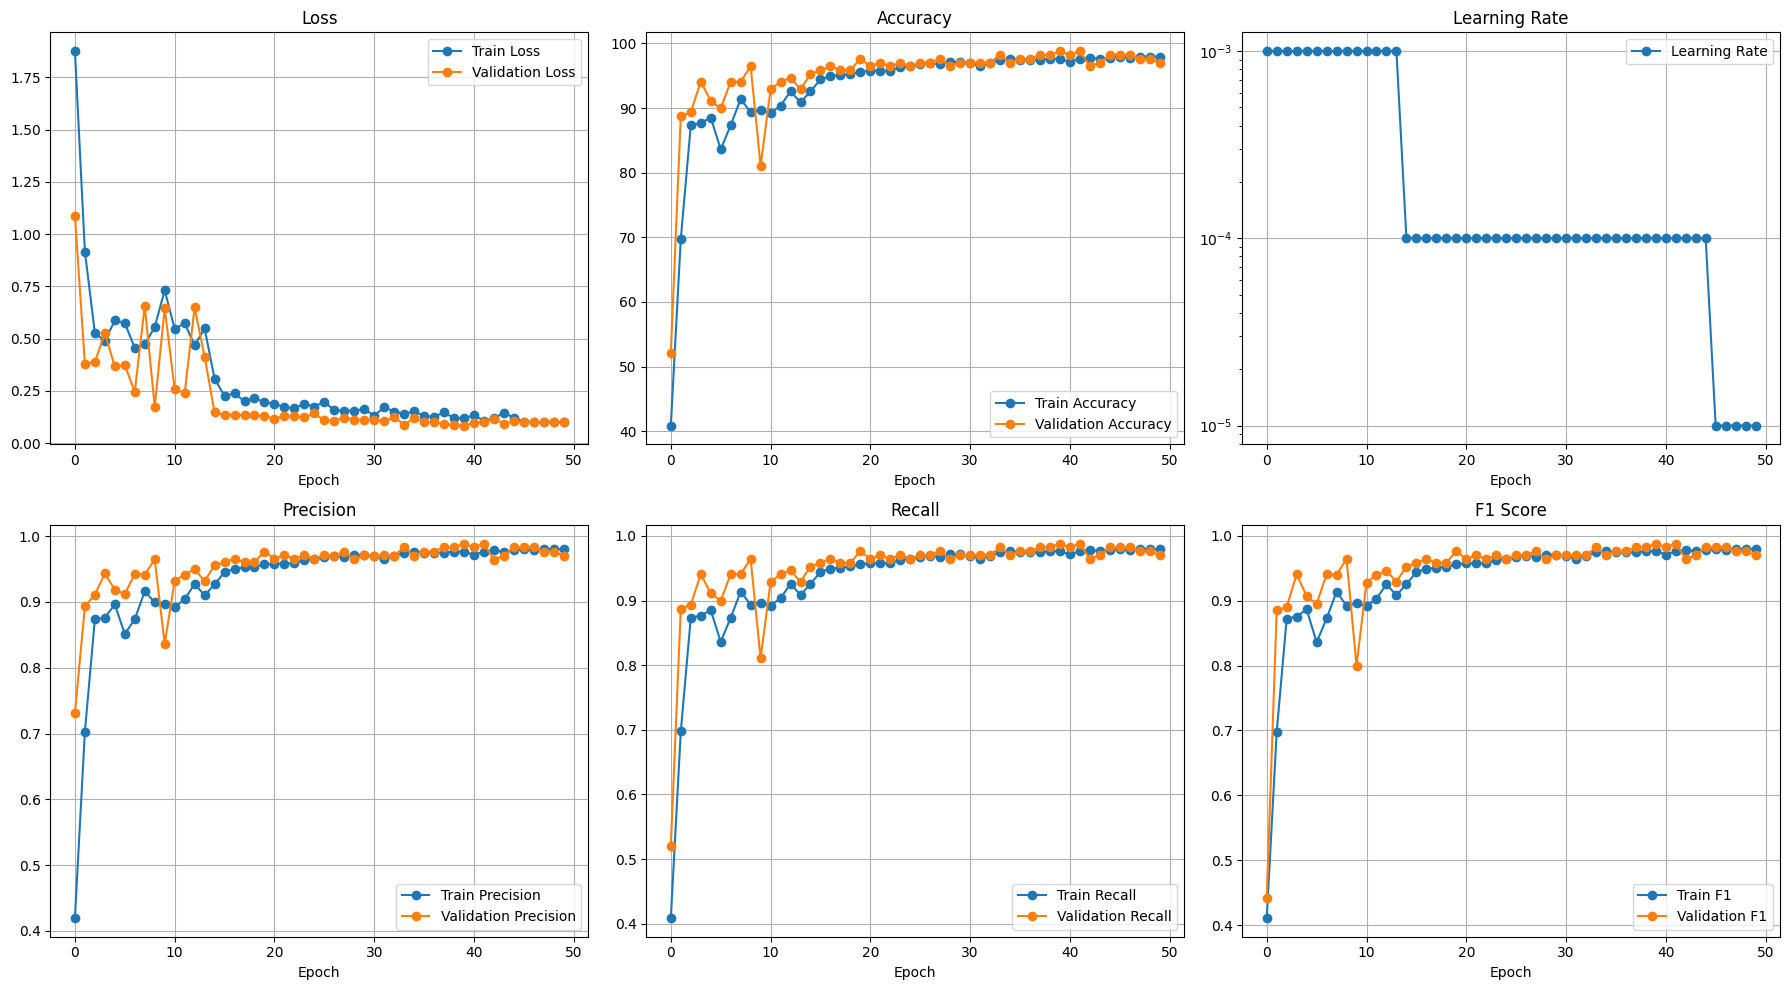

Loading checkpoint from /content/gdrive/MyDrive/yoga_proj/nov16_unknown_attention/best_model.pth
Resuming training from epoch 40


Testing: 100%|██████████| 6/6 [00:32<00:00,  5.45s/it]


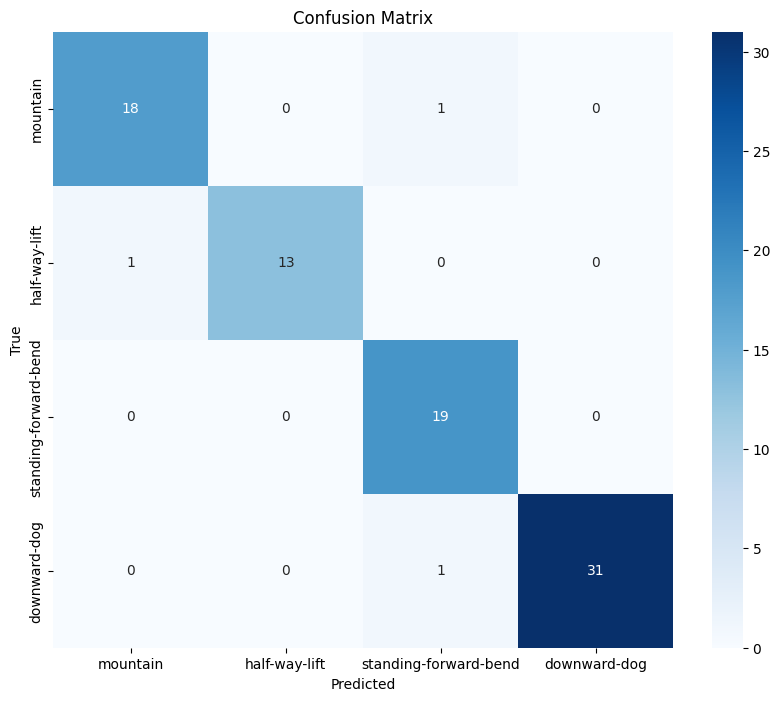

Test Loss: 0.3798
Test Accuracy: 96.43%


In [24]:
main()